In [1]:
%load_ext autoreload
%autoreload 2

# Monopole source in homogeneous media

This notebook closely follows the k-Wave example given [in this page](http://www.k-wave.org/documentation/example_tvsp_homogeneous_medium_monopole.php).

The following code integrates the wave equation for an homogeneous region with a mass source.

## Setup the problem

In [2]:
from jax import numpy as jnp
from matplotlib import pyplot as plt

In [3]:
# Defining geometry
from jwave.geometry import kGrid, TimeAxis, Medium, Sources

N = (256, 256)
dx = (0.5, 0.5)
cfl = 0.1

grid = kGrid.make_grid(N, dx)

# Physical properties
medium = Medium(
    sound_speed=jnp.ones(N),
    density=jnp.ones(N),
    attenuation=0.0,
    pml_size=20
)

time_array = TimeAxis.from_kgrid(grid, medium, cfl=cfl, t_end=50.)

In [4]:
# define a source point
from jwave.signal_processing import apply_ramp

source_freq = .3
source_mag = 5/time_array.dt

def gaussian_window(signal, time, mu, sigma):
    return signal*jnp.exp(
        -(t-mu)**2/sigma**2
    )

t = jnp.arange(0, time_array.t_end, time_array.dt)
s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
s1 = gaussian_window(
    apply_ramp(s1, time_array.dt, source_freq),
    t,
    10,
    3
)

source_signals = jnp.stack([s1])
source_positions = ([100], [100])

sources = Sources(positions=source_positions, signals=source_signals)

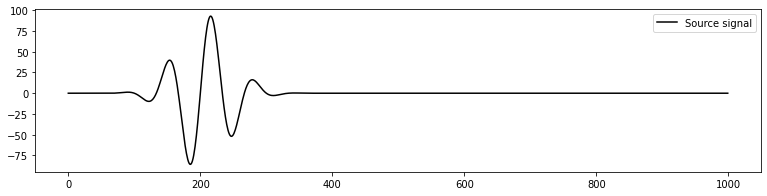

In [5]:
plt.figure(figsize=(13,3))
plt.plot(s1, label="Source signal", c='k')
plt.legend()

## Run the simulation

Keep in mind that the simulator returns the acoustic velocity and density. The latter should be converted to pressure using the relationship

$$
p = c^2\sum_\eta \rho_\eta
$$

In [6]:
print("Time steps: {}".format(int(time_array.t_end/time_array.dt)))

Time steps: 999


In [7]:
# Run simulation
from jwave.physics import simulate_wave_propagation

fields = simulate_wave_propagation(grid, medium, time_array, sources)
u = fields[0]
p = jnp.sum(fields[1],1)*(medium.sound_speed**2)

(256, 256) (2, 256, 256)
(2, 256, 256) (2, 256, 256)


/home/astanziola/anaconda3/envs/jwave/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/astanziola/anaconda3/envs/jwave/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


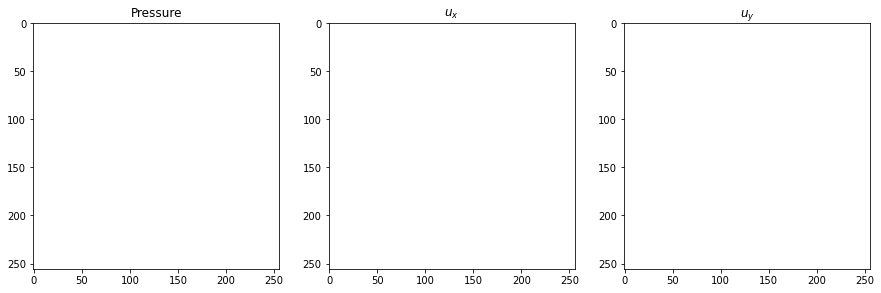

In [8]:
# Show results
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].imshow(p[-1], cmap="seismic")
ax[0].set_title("Pressure")
ax[1].imshow(u[-1,0], cmap="seismic")
ax[1].set_title("$u_x$")
ax[2].imshow(u[-1,1], cmap="seismic")
ax[2].set_title("$u_y$")

plt.show()

Text(0.5, 1.0, 'Amplitude')

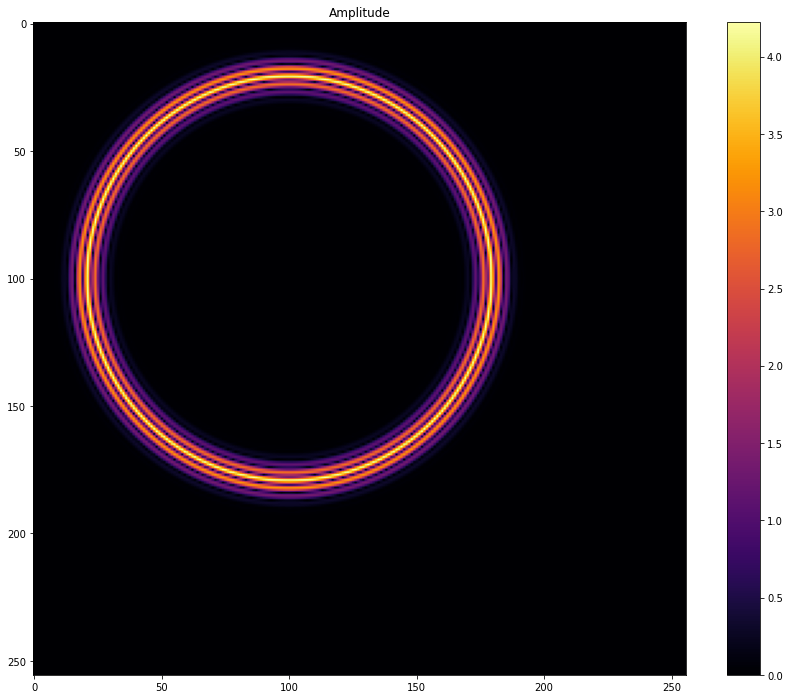

In [8]:
plt.figure(figsize=(15,12))
plt.imshow(jnp.abs(p[-1]), cmap="inferno")
plt.colorbar()
plt.title("Amplitude")

In [9]:
%timeit simulate_wave_propagation(grid, medium, time_array, sources)

286 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
# Compiling the function
from jax import jit

wave_prop = jit(lambda m,s: simulate_wave_propagation(grid,m,time_array,s))
_ = wave_prop(medium, sources)

In [11]:
%timeit  wave_prop(medium, sources)

135 ms ± 350 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
